# A/B Testing: Landing Page Impact on Conversion

This project analyzes whether a new landing page (B) leads to a higher newsletter sign-up rate than the current page (A). The dataset is from a real A/B test and includes two separate files:
- `ab_data.csv`: A/B test logs (user_id, timestamp, group, landing_page, converted)
- `countries.csv`: User geographic information

We'll clean, merge, analyze, and statistically test the dataset to determine the impact of the page variation.


In [38]:
# Import the needed libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind
warnings.filterwarnings('ignore') # Don't show warning errors
%matplotlib inline


# Set Visuals style
sns.set(style='ticks', palette='bright')

## Step 1: Load and Inspect Data

We load both CSV files and merge them on `user_id` to include country information in the main dataset.

In [39]:
# Load the files
ab_data = pd.read_csv(r"C:\Users\pc\Desktop\A or B\ab_data.csv")
countries = pd.read_csv(r"C:\Users\pc\Desktop\A or B\countries.csv")

# Preview
print('ab_data: \n', ab_data.head(), '\n')
print('countries: \n', countries.head())

ab_data: 
    user_id timestamp      group landing_page  converted
0   851104   11:48.6    control     old_page          0
1   804228   01:45.2    control     old_page          0
2   661590   55:06.2  treatment     new_page          0
3   853541   28:03.1  treatment     new_page          0
4   864975   52:26.2    control     old_page          1 

countries: 
    user_id country
0   834778      UK
1   928468      US
2   822059      UK
3   711597      UK
4   710616      UK


## Step 2: Merge and Clean Data

- Merge datasets on `user_id`
- Drop duplicate entries
- Fix mismatches between group and landing_page (e.g., control shouldn't be seeing 'new_page')
- Drop rows with missing or inconsistent values


In [40]:
# Merge datasets
df = ab_data.merge(countries, on='user_id', how='left')

# Drop duplicates
df.drop_duplicates(inplace=True)

# Ensure 'group' matches 'landing_page'
df = df[((df['group'] == 'control') & (df['landing_page'] == 'old_page')) |
        ((df['group'] == 'treatment') & (df['landing_page'] == 'new_page'))]

# Ensure the column timestamp is renamed properly
df.rename(columns={'timestamp': 'session_duration'}, inplace=True)

# Function to convert MM:SS.s format to total seconds
def duration_to_seconds(duration_str):
    try:
        mins, secs = duration_str.split(":")
        return int(mins) * 60 + float(secs)
    except:
        return np.nan

# Apply the function
df['session_seconds'] = df['session_duration'].apply(duration_to_seconds)

# Drop rows where conversion failed
df = df.dropna(subset=['session_seconds'])

# Check for nulls
print('missing values: \n', df.isnull().sum())

missing values: 
 user_id             0
session_duration    0
group               0
landing_page        0
converted           0
country             0
session_seconds     0
dtype: int64


In [41]:
# Check the df
df.head()

,user_id,session_duration,group,landing_page,converted,country,session_seconds
0,851104,11:48.6,control,old_page,0,US,708.6
1,804228,01:45.2,control,old_page,0,US,105.2
2,661590,55:06.2,treatment,new_page,0,US,3306.2
3,853541,28:03.1,treatment,new_page,0,US,1683.1
4,864975,52:26.2,control,old_page,1,US,3146.2


In [42]:
# Check df overall info
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 290587 entries, 0 to 294481
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           290587 non-null  int64  
 1   session_duration  290587 non-null  object 
 2   group             290587 non-null  object 
 3   landing_page      290587 non-null  object 
 4   converted         290587 non-null  int64  
 5   country           290587 non-null  object 
 6   session_seconds   290587 non-null  float64
dtypes: float64(1), int64(2), object(4)
memory usage: 17.7+ MB


## Step 3: Exploratory Data Analysis

We'll check:
- User counts by group
- Conversion rates
- Conversion by country (optional segmentation)


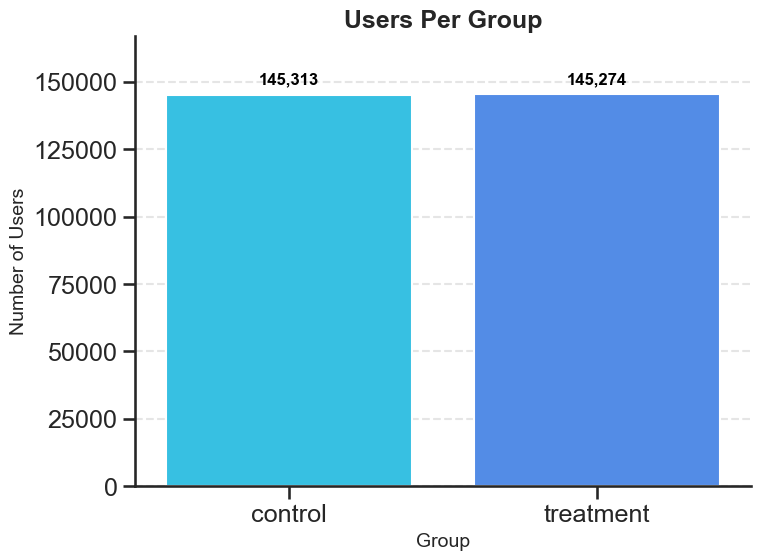

In [79]:
# Style setup
sns.set(style="ticks", context="talk", font_scale=1.1)
plt.figure(figsize=(8, 6))

# Bright color palette
bright_colors = ["#1AD1FF", '#3A86FF']  # yellow & electric blue

# Plot
bar = sns.countplot(x='group', data=df, palette=bright_colors)

# Add value labels on bars
group_counts = df['group'].value_counts()
for i, val in enumerate(group_counts):
    bar.text(i, val + max(group_counts)*0.02, f'{val:,}', ha='center', va='bottom',
             fontsize=12, fontweight='bold', color='black')

# Title and labels
plt.title('Users Per Group', fontsize=18, fontweight='bold')
plt.xlabel('Group', fontsize=14)
plt.ylabel('Number of Users', fontsize=14)

# Y-axis limit
plt.ylim(0, max(group_counts) * 1.15)

# Clean look
sns.despine()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

# Show plot
plt.show()


In [44]:
# Conversion rates by group
conversion_rates = df.groupby('group')['converted'].agg(['sum', 'count'])
conversion_rates['conversion_rate'] = conversion_rates['sum']/conversion_rates['count']
conversion_rates

,sum,count,conversion_rate
group,,,
control,17489,145274,0.120386
treatment,17264,145313,0.118806


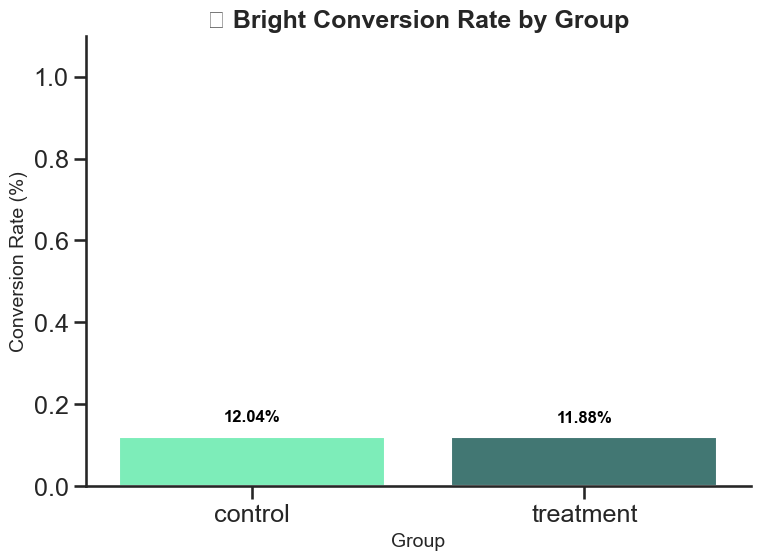

In [80]:
# Set style
sns.set(style="ticks", context="talk", font_scale=1.1)
plt.figure(figsize=(8, 6))

# Bright color palette
bright_palette = ["#6BFFBA", "#39807B"]  # bright coral & aqua

# Barplot
bar = sns.barplot(
    x=conversion_rates.index,
    y=conversion_rates['conversion_rate'],
    palette=bright_palette,
    ci=None
)

# Annotate bars
for i, val in enumerate(conversion_rates['conversion_rate']):
    bar.text(i, val + 0.03, f"{val:.2%}", ha='center', va='bottom',
             fontsize=12, fontweight='bold', color='black')

# Titles and labels
plt.title("💡 Bright Conversion Rate by Group", fontsize=18, fontweight='bold')
plt.ylabel("Conversion Rate (%)", fontsize=14)
plt.xlabel("Group", fontsize=14)
plt.ylim(0, 1.1)

# Style cleanup
sns.despine()
plt.grid(False)
plt.tight_layout()

# Show plot
plt.show()


## Step 4 : Country-Level Insights

We can analyze conversion rates by country and check if certain regions responded differently to the test.

In [46]:
country_conversion = df.groupby('country')['converted'].agg(['sum', 'count'])
country_conversion['conversion_rate'] = country_conversion['sum']/country_conversion['count']
# Sort the values in the country_conversion_rate column in descending order
country_conversion.sort_values('conversion_rate', ascending=False).head()

,sum,count,conversion_rate
country,,,
UK,8739,72466,0.120594
US,24342,203622,0.119545
CA,1672,14499,0.115318


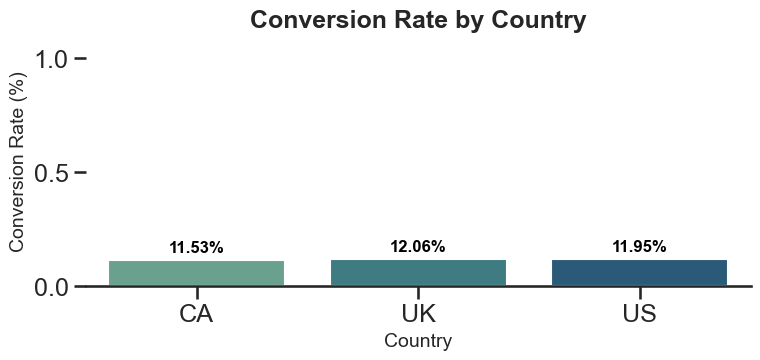

In [63]:
# Set aesthetic style
sns.set(style="ticks", context="talk", font_scale=1.1)

# Set color palette
palette = sns.color_palette("crest", len(country_conversion))

# Create figure
plt.figure(figsize=(8, 4))
bar = sns.barplot(
    x=country_conversion.index,
    y=country_conversion['conversion_rate'],
    palette=palette
)

# Annotate each bar
for i, rate in enumerate(country_conversion['conversion_rate']):
    bar.text(i, rate + 0.02, f"{rate:.2%}", ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

# Titles and labels
plt.title('Conversion Rate by Country', fontsize=18, fontweight='bold')
plt.ylabel('Conversion Rate (%)', fontsize=14)
plt.xlabel('Country', fontsize=14)
plt.ylim(0, 1.1)

# Style tweaks
plt.xticks()
sns.despine(left=True)
plt.tight_layout()
plt.grid(False)

# Show it
plt.show()


## Step 5: A/B Statistical Test

We perform a two-proportion z-test to compare conversion rates between control and treatment groups.

- H₀: Conversion rates are the same.
- H₁: Conversion rates are different.


In [48]:
# Z-test setup
success = conversion_rates['sum'].values
trials = conversion_rates['count'].values

# Perform Z-test
z_stat, p_value = proportions_ztest(success, trials)
print(f'z-stat: {z_stat: .3f}, p-value: {p_value: .3f}')

if p_value < 0.05:
    print('✅ Statistically significant difference in conversion rates.')
else:
    print('⚠️ No statistically significant difference')

z-stat:  1.313, p-value:  0.189
⚠️ No statistically significant difference


## Step 6: Visualize Confidence Intervals

We’ll calculate and plot the 95% confidence intervals for conversion rates in each group.


In [49]:
# Confidence Interval
conversion_rates['se'] = np.sqrt(
    conversion_rates['conversion_rate'] * (1 - conversion_rates['conversion_rate']) / conversion_rates['count']
)
conversion_rates['ci_lower'] = conversion_rates['conversion_rate'] - 1.96 * conversion_rates['se']
conversion_rates['ci_lower'] = conversion_rates['conversion_rate'] + 1.96 * conversion_rates['se']

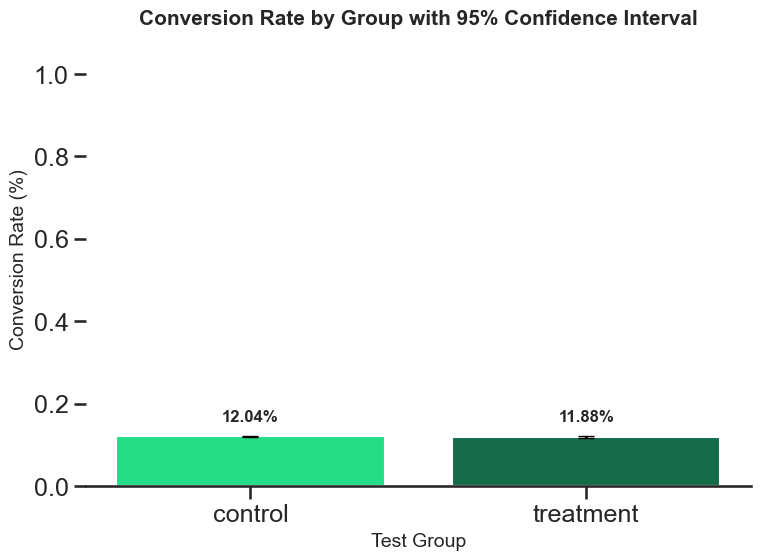

In [64]:
# Prepare data
conv_plot = conversion_rates.reset_index()

# Aesthetic setup
sns.set(style="ticks", context="talk", font_scale=1.1)

# Figure setup
plt.figure(figsize=(8, 6))

# Barplot
sns.barplot(
    x='group',
    y='conversion_rate',
    data=conv_plot,
    capsize=0.1,
    palette=["#05FC89", "#067A4C"]  # Control = Blue, Treatment = Red
)

# Add error bars manually (95% CI)
plt.errorbar(
    x=[0, 1],
    y=conv_plot['conversion_rate'],
    yerr=1.96 * conv_plot['se'],
    fmt='none',
    c='black',
    capsize=6,
    linewidth=2
)

# Annotate bars with percentages
for i, val in enumerate(conv_plot['conversion_rate']):
    plt.text(i, val + 0.03, f"{val:.2%}", ha='center', va='bottom', fontsize=12, fontweight='bold')

# Titles and labels
plt.title('Conversion Rate by Group with 95% Confidence Interval', fontsize=15, fontweight='bold')
plt.ylabel('Conversion Rate (%)', fontsize=14)
plt.xlabel('Test Group', fontsize=14)
plt.ylim(0, 1.1)

# Style tweaks
sns.despine(left=True)
plt.grid(False)
plt.tight_layout()

# Show plot
plt.show()


## Step 7: Compare Average Time on Page by Group

We’ll calculate the average session duration in seconds by group.

In [51]:
# Average session duration in seconds by group
avg_time = df.groupby('group')['session_seconds'].agg(['mean', 'count', 'std'])
avg_time['mean'] = avg_time['mean'].round(2)
avg_time

,mean,count,std
group,,,
control,1804.93,145274,1036.966970
treatment,1801.52,145313,1039.092665


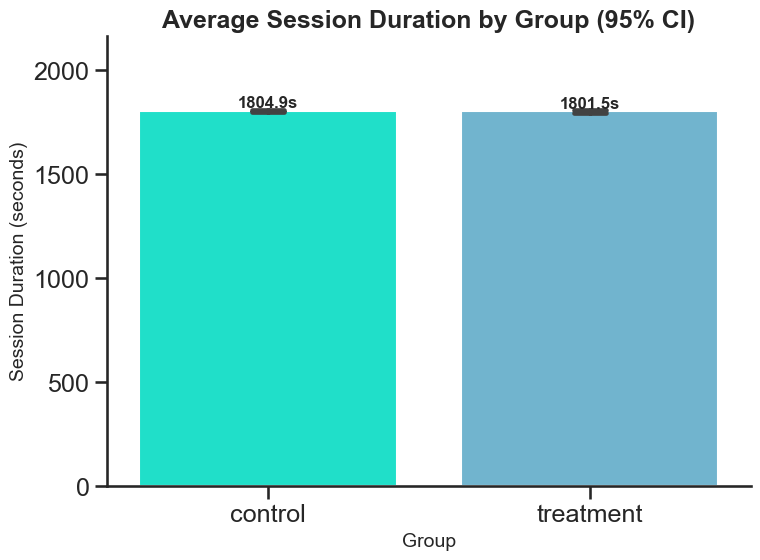

In [66]:
# Set visual theme
sns.set(style="ticks", context="talk", font_scale=1.1)

# Set up the plot
plt.figure(figsize=(8, 6))
bar = sns.barplot(
    x='group',
    y='session_seconds',
    data=df,
    estimator=np.mean,
    ci=95,
    capsize=0.1,
    palette=["#00ffe1", "#61bbde"]  # Custom colors for control & treatment
)

# Add value labels above bars
group_means = df.groupby('group')['session_seconds'].mean().values
for i, val in enumerate(group_means):
    bar.text(i, val + 2, f"{val:.1f}s", ha='center', va='bottom', fontsize=12, fontweight='bold')

# Titles and labels
plt.title("Average Session Duration by Group (95% CI)", fontsize=18, fontweight='bold')
plt.ylabel("Session Duration (seconds)", fontsize=14)
plt.xlabel("Group", fontsize=14)

# Y-axis limits and grid
plt.ylim(0, max(group_means)*1.2)
plt.grid(False)

# Styling
sns.despine()
plt.tight_layout()

# Show plot
plt.show()


**Statistical Test (t-test)**

Let’s test if the difference in session time between groups is statistically significant.

In [53]:
# Split the data into control time and treatment time
control_times = df[df['group'] == 'control']['session_seconds']
treatment_times = df[df['group'] =='treatment']['session_seconds']

#Run t-test
t_stat, p_val = ttest_ind(control_times, treatment_times, equal_var=False)

print(f'T Statistics: {t_stat: .3f}, p-value: {p_val: .3f}')

if p_val < 0.05:
    print('✅ Significant difference in session duration between the groups')
else:
    print('⚠️ No Significant difference in session duration between the groups')


T Statistics:  0.883, p-value:  0.377
⚠️ No Significant difference in session duration between the groups


**Histogram or KDE Comparison**

Comparing overall distribution

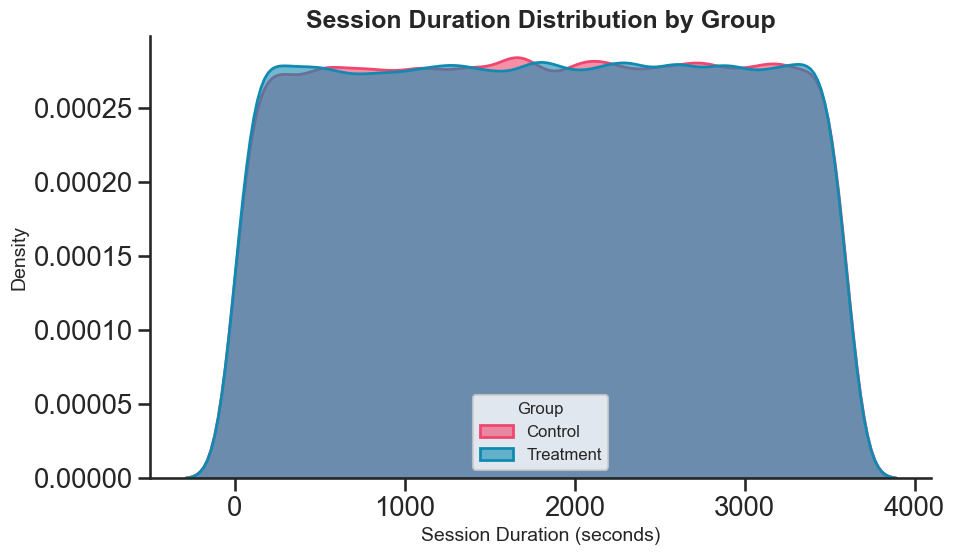

In [74]:
# Aesthetic settings
sns.set(style="ticks", context="talk", font_scale=1.2)

# Create figure
plt.figure(figsize=(10, 6))

# KDE plots with enhancements
sns.kdeplot(
    control_times,
    label='Control',
    fill=True,
    linewidth=2,
    color="#EF476F",  # Vibrant coral
    alpha=0.6
)

sns.kdeplot(
    treatment_times,
    label='Treatment',
    fill=True,
    linewidth=2,
    color="#118AB2",  # Cool blue
    alpha=0.6
)

# Plot titles and labels
plt.title("Session Duration Distribution by Group", fontsize=18, fontweight="bold")
plt.xlabel("Session Duration (seconds)", fontsize=14)
plt.ylabel("Density", fontsize=14)

# Legend styling
plt.legend(title="Group", title_fontsize=12, fontsize=12)

# Style and spacing
plt.grid(False)
sns.despine()
plt.tight_layout()

# Show plot
plt.show()


## 🧾 Conclusion

- **Conversion Rate:** There was **no statistically significant difference** between the two groups (*p = 0.189*).
- **Time on Page:** Users in the treatment group spent **less time** on the page compared to the control group, but the difference was **not statistically significant** (*p = 0.377*).

This suggests that the new landing page **did not lead to a meaningful improvement in conversion rates** or user engagement (measured by session duration).

🧠 **Takeaway**: A/B testing reveals not just what changes *should* be made, but also what *shouldn’t*. In this case, the new design did not outperform the original. It's crucial to measure behavioral metrics like time spent on page — they offer deeper UX insight even when conversions don’t change.
